# Testing GCM's perfomance when there's a backdoor

In [92]:
from dowhy import gcm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Creating the GCM

#### Setting the DAG

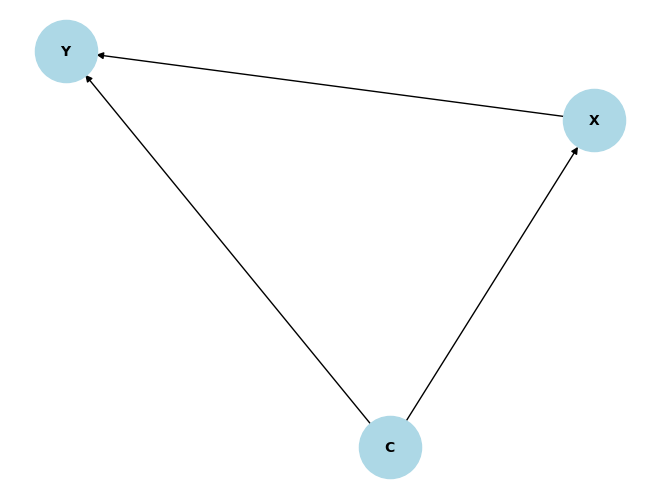

In [93]:
causal_graph = nx.DiGraph([
    ('C', 'X'),
    ('X', 'Y'),
    ('C', 'Y'),
])

causal_model = gcm.StructuralCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

In this example, $C$ is a confounder and the path $X \leftarrow C \rightarrow Y$ forms a backdoor path between X and Y, which could compromise the causal effect estimation between the two if it isn't accounted for.

#### Generating data

In [94]:
# Set a random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Step 1: Generate C as a continuous variable (e.g., from a normal distribution)
C = np.random.normal(loc=0, scale=1, size=n_samples)  # Mean 0, standard deviation 1

# Step 2: Generate X as a function of C with added noise
X = 2 * C + np.random.normal(loc=0, scale=0.5, size=n_samples)  # Linear function of C with noise

# Step 3: Generate Y as a function of both X and C with added noise
Y = 3 * X + 1.5 * C + np.random.normal(loc=0, scale=1, size=n_samples)  # Linear combination of X and C with noise

# Create a DataFrame to store the generated data
data = pd.DataFrame({'C': C, 'X': X, 'Y': Y})

# Display the first few rows of the generated data
data.head()


,C,X,Y
0,0.496714,1.693106,5.149211
1,-0.138264,0.185788,0.205450
2,0.647689,1.325192,4.154690
3,1.523030,2.722591,10.144357
4,-0.234153,-0.119195,-2.602430


#### Setting the causal mechanisms

We will automatically assign a causal mechanism to each of the variables, given the graph and the generated data. For the exogenous variable $C$, it should assign an Empirical Distribution. For the endogenous variables $X$ and $Y$, since they are continuous, it should assign an Additive Noise Model. 

In [95]:
gcm.auto.assign_causal_mechanisms(causal_model, data)

#### Fitting the model and generating new data

In [96]:
gcm.fit(causal_model, data)
generated_data = gcm.draw_samples(causal_model, num_samples=1000)
print(generated_data.head())

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 429.66it/s]

          C         X          Y
0 -0.637387 -0.710887  -3.621693
1  0.538910  1.869126   4.570256
2 -2.025143 -3.972251 -13.599728
3 -2.025143 -3.581597 -13.368358
4 -0.485364 -1.025866  -2.634138


### Calculating the ACE

In [97]:
gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: '1'},
                         interventions_reference={'X': lambda x: '0'},
                         num_samples_to_draw=1000)

### Estimating confidence intervals (Confidence level = 0.95)

In [98]:
gcm.confidence_intervals(lambda: gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: '1'},
                         interventions_reference={'X': lambda x: '0'},
                         num_samples_to_draw=1000))

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:00<00:00, 106.59it/s]


(array([2.98649596]), array([[2.94055752, 3.01028812]]))

Considering $Y = 3X + 1.5C + \epsilon (\epsilon: Noise)$, the value we were looking for was 3, the causal effect of $X$ on $Y$. In that case, the result seems satisfactory.
